Basic Predictions
===============

This notebook tries to predict number of "confirmed cases" from patientdb available at http://api.covid19india.org/. 

Growth rate is computed as rate of change of confirmed cases and smoothened using a 7d rolling average.
It is extrapolated using the following methods:
* Quadartic curve fitting - fails to fit the curve correctly
* Hyperbolic curve fitting using a neural net - fits well and asymptotes the growth rate at ~7%.

The model is rudimentary and points towards a scenario where we fail to contain the epidemic and it eventually moves to stage 3/4.

In [84]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import matplotlib as mpl
from matplotlib.dates import date2num, AutoDateLocator, ConciseDateFormatter, DayLocator, AutoDateFormatter

import datetime as dt
import pandas as pd
import numpy as np
import requests

from sklearn.neural_network import MLPRegressor

In [85]:
# download data
rd1 = requests.get("https://api.covid19india.org/raw_data1.json") #eod apr 19th
rd2 = requests.get("https://api.covid19india.org/raw_data2.json") #eod apr 26th
rd3 = requests.get("https://api.covid19india.org/raw_data3.json") #eod current

# make dfs
df1 = pd.DataFrame(rd1.json()['raw_data'])
df2 = pd.DataFrame(rd2.json()['raw_data'])
df3 = pd.DataFrame(rd3.json()['raw_data'])



In [86]:
# # download patient data
# r = requests.get("https://api.covid19india.org/raw_data.json")

# o = r.json()
# df_orig = pd.DataFrame(o['raw_data'])

In [104]:
# # format and clean
# df_orig['dateannounced'] = pd.to_datetime(df_orig['dateannounced'], format="%d/%m/%Y")
# df = df_orig[(df_orig.currentstatus!="") & (df_orig.detectedstate!="")]
# print("Records:", len(df))

df1['dateannounced'] = pd.to_datetime(df1['dateannounced'], format="%d/%m/%Y")
df1 = df1[(df1.currentstatus!="") & (df1.detectedstate!="")]
print("Records:", len(df1))

df2['dateannounced'] = pd.to_datetime(df2['dateannounced'], format="%d/%m/%Y")
df2 = df2[(df2.currentstatus!="") & (df2.detectedstate!="")]
print("Records:", len(df2))

df3['dateannounced'] = pd.to_datetime(df3['dateannounced'], format="%d/%m/%Y")
df3 = df3[(df3.currentstatus!="") & (df3.detectedstate!="")]
print("Records:", len(df3))


sdf = df1.append([df2, df3], sort=True)
print("Records:", len(sdf))



Records: 17305
Records: 10585
Records: 10002
Records: 37892


In [88]:
# inspect
# print("COLS:\n" + str(df.columns))
# print("STATUS:\n" + str(df.currentstatus.value_counts()))
print("COLS:\n" + str(sdf.columns))
print("STATUS:\n" + str(sdf.currentstatus.value_counts()))


COLS:
Index(['agebracket', 'backupnotes', 'contractedfromwhichpatientsuspected',
       'currentstatus', 'dateannounced', 'detectedcity', 'detecteddistrict',
       'detectedstate', 'entryid', 'estimatedonsetdate', 'gender',
       'nationality', 'notes', 'numcases', 'patientnumber', 'source1',
       'source2', 'source3', 'statecode', 'statepatientnumber',
       'statuschangedate', 'typeoftransmission'],
      dtype='object')
STATUS:
Hospitalized    35521
Recovered        1685
Deceased          685
Migrated            1
Name: currentstatus, dtype: int64


,daily,total,growth,sma_growth
dateannounced,,,,
2020-05-05,943,33698,2.878950,2.255748
2020-05-06,1159,34857,3.439373,2.504268
2020-05-07,909,35766,2.607798,2.603453
2020-05-08,1085,36851,3.033607,2.730351
2020-05-09,1041,37892,2.824889,2.834337


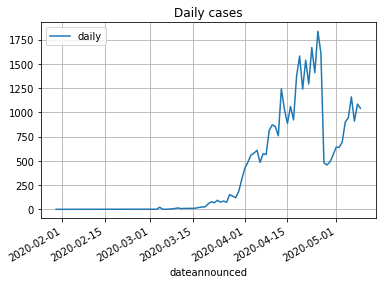

In [89]:
# group by date
by_date = sdf.groupby(by='dateannounced')['patientnumber'].count().to_frame()
by_date = by_date.rename(columns={'patientnumber': 'daily'})

# cum sum
cumsum = by_date.cumsum()
by_date['total'] = cumsum['daily']

# calc growth rate & its moving avg
by_date['growth'] = 100 * by_date['daily'] / (by_date['total'] - by_date['daily'])
sma_gr = by_date['growth'].rolling('7d').mean()
by_date['sma_growth'] = sma_gr

# daily plot
by_date.plot(y='daily', kind='line', title="Daily cases", grid='True')
by_date.tail()

In [97]:
# create extrapolation dataframe
last_date = by_date.index[-1]
projections = pd.DataFrame(index=by_date.index.union(pd.date_range(start=last_date, periods=150, freq="1d")))

# fill with orig df
projections['daily'] = by_date['daily']
projections['total'] = by_date['total']
projections['sma_growth'] = by_date['sma_growth']
projections['day_of_yr'] = projections.index.dayofyear

# filter data for curve fitting (aka training data)
end_idx = len(by_date)
start_idx = end_idx - 26 # use 21 day sma data for curve fitting
fit_df = projections[start_idx:end_idx]
fit_df.tail()

,daily,total,sma_growth,day_of_yr
2020-05-05,943.0,33698.0,2.255748,126
2020-05-06,1159.0,34857.0,2.504268,127
2020-05-07,909.0,35766.0,2.603453,128
2020-05-08,1085.0,36851.0,2.730351,129
2020-05-09,1041.0,37892.0,2.834337,130


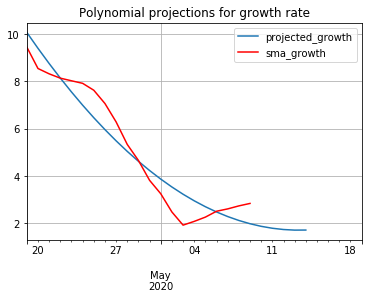

In [91]:
# fit polynomial curve
coeffs = np.polyfit(fit_df.day_of_yr, fit_df.sma_growth, 2) # 2nd degree
extrapolation_eqn = np.poly1d(coeffs)
projections['projected_growth'] = extrapolation_eqn(projections.day_of_yr)

    # x axis ticks
mj_l = AutoDateLocator()
mj_f = ConciseDateFormatter(mj_l, show_offset=False)
mn_l = DayLocator()
  
       
ax.xaxis.set_major_formatter(mj_f)
ax.xaxis.set_minor_locator(mn_l)

ax = projections[start_idx:end_idx+5].plot(y='projected_growth', grid='True')
   
ax.xaxis.set_major_formatter(mj_f)
ax.xaxis.set_minor_locator(mn_l)

_ = projections[start_idx:end_idx+10].plot(y='sma_growth', color='red', grid=True, title="Polynomial projections for growth rate", ax=ax)

In [98]:
# train a neural network with hyperbolic activation function from day_of_yr => sma_growth
regressor = MLPRegressor(hidden_layer_sizes = (100,), activation = 'tanh', solver='lbfgs', max_iter=500)
_ = regressor.fit(X=fit_df[['day_of_yr']], y=fit_df['sma_growth'])

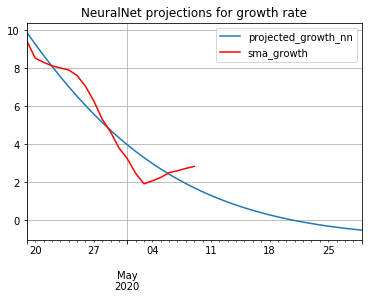

In [99]:
projections['projected_growth_nn'] = regressor.predict(X=projections[['day_of_yr']])
ax = projections[start_idx:end_idx+20].plot(y='projected_growth_nn', grid=True)
_ = projections[start_idx:end_idx+20].plot(y='sma_growth', color='red', title="NeuralNet projections for growth rate", ax=ax, grid='True')

In [100]:
# compute total and daily numbers based on projected rate
prev_row_total = 0
def project(row):
    global prev_row_total
    if not np.isnan(row['total']):
        prev_row_total = row['total']
        return row['total']
    prev_row_total *= (1 + row['projected_growth_nn']/100)
    return prev_row_total

projections['projected_total'] = projections.apply(project, axis=1).astype('int64')

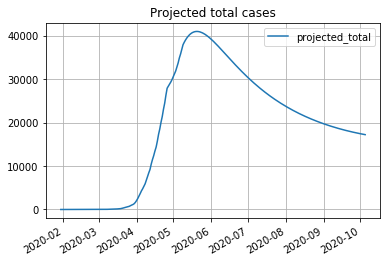

In [105]:
# plot 100 days from feb 1
_ = projections[0:100].plot(y='projected_total', title="Projected total cases", grid='True')

 
# projections[0:100].set_major_formatter(mj_f)
# projections[0:100].xaxis.set_minor_locator(mn_l)


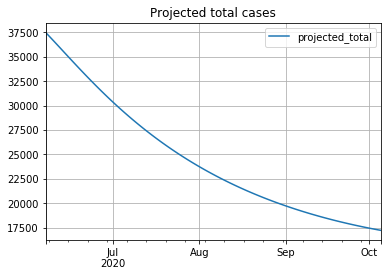

In [102]:
# plot next 100 days  
_ = projections[100:].plot(y='projected_total', title="Projected total cases", grid='True')